# Let us check the output of Smica propagation code

In [1]:
import numpy as np
import pandas as pd
from healpy.sphtfunc import smoothing
import smica
import os
import json
import component_separation
import component_separation.io as io
import healpy as hp
import component_separation.MSC.MSC.pospace as ps
import component_separation.powspec as pw
import component_separation.preprocess as prep
from component_separation.cs_util import Config as csu
from component_separation.cs_util import Constants as const
from component_separation.cs_util import Helperfunctions as hpf
from component_separation.cs_util import Planckf, Planckr, Plancks
import matplotlib.pyplot as plt
with open(os.path.dirname(component_separation.__file__)+'/config.json', "r") as f:
    cf = json.load(f)
    
import platform
uname = platform.uname()
if uname.node == "DESKTOP-KMIGUPV":
    mch = "XPS"
else:
    mch = "NERSC"
    
CMB = dict()
almT, almE, almB = dict(), dict(), dict()


MSC: reverting to standard healpy


/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/pyfits/__init__.py:21: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  warnings.warn('PyFITS is deprecated, please use astropy.io.fits',


In [3]:
data = io.load_plamap(cf, field=(0,1,2))
lmax = 1500
names = ["030", "044", "070", "100", "143", "217", "353", "545", "857"]
nside = 512
smica_W_pol = np.loadtxt("/global/homes/s/sebibel/data/weights/weights_EB_smica_R3.00.txt").reshape(2,7,4001)
smica_W_t = np.loadtxt("/global/homes/s/sebibel/data/weights/weights_T_smica_R3.00_Xfull.txt")
# data = prep.preprocess_all(data)

ndet=7
D_lS = pd.read_csv(
        cf[mch]['powspec_truthfile'],
        header=0,
        sep='    ',
        index_col=0)
D_lS_EE = D_lS["Planck-"+"EE"].to_numpy()
C_lS_EE = D_lS_EE[:lmax+1]/hpf.llp1e12(np.array([range(lmax+1)]))
cov_lS_EE = np.ones((ndet,ndet,lmax+1)) * C_lS_EE * 1e12

/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/fitsfunc.py:391: UserWarning: NSIDE = 1024
  warnings.warn("NSIDE = {0:d}".format(nside))
/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/fitsfunc.py:400: UserWarning: ORDERING = NESTED in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/

loaded {'030': '/global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20_sim/0200/npipe6v20_030_map.fits', '044': '/global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20_sim/0200/npipe6v20_044_map.fits', '070': '/global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20_sim/0200/npipe6v20_070_map.fits', '100': '/global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20_sim/0200/npipe6v20_100_map.fits', '143': '/global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20_sim/0200/npipe6v20_143_map.fits', '217': '/global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20_sim/0200/npipe6v20_217_map.fits', '353': '/global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20_sim/0200/npipe6v20_353_map.fits'}


In [49]:
almT, almE, almB = dict(), dict(), dict()
for name in names[:-2]:
    alms = hp.map2alm(hp.ud_grade(data[name], nside_out=nside), lmax, iter=0) # full sky QU->EB
    almT[name] = alms[0]
    almE[name] = alms[1]
    almB[name] = alms[2]

In [79]:
nalm = int((lmax+1)*(lmax+2)/2)  
combalmT = np.zeros((nalm), dtype=np.complex128)
combalmE = np.zeros((nalm), dtype=np.complex128)
combalmB = np.zeros((nalm), dtype=np.complex128)
for m,name in zip(range(len(names[:-2])),names[:-2]):
    print(m, name)
    combalmT += hp.almxfl(almT[name], np.squeeze(smica_W_t[m,:]))
    combalmE += hp.almxfl(almE[name], np.squeeze(smica_W_pol[0,m,:]))
    combalmB += hp.almxfl(almB[name], np.squeeze(smica_W_pol[1,m,:]))

0 030
1 044
2 070
3 100
4 143
5 217
6 353


In [80]:
print(CMB["BB"].shape)

(1127251,)


In [86]:
CMB["TT"] = hp.almxfl(combalmT, hp.pixwin(nside)[0:lmax])
CMB["EE"] = hp.almxfl(combalmE, hp.pixwin(nside, pol=True)[0][0:lmax])
CMB["BB"] = hp.almxfl(combalmB, hp.pixwin(nside, pol=True)[1][0:lmax])

CMB["TQU"] = hp.alm2map([CMB["TT"], CMB["EE"], CMB["BB"]], nside)

In [87]:
cl = hp.anafast(CMB["TQU"])

Text(0.5, 1.0, '')

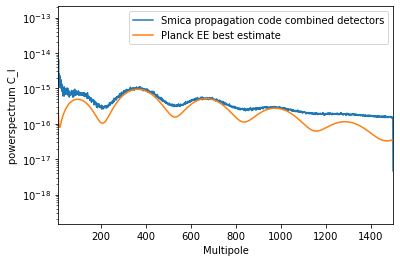

In [102]:
for n in [1]:#range(1):
    plt.plot(cl[n,:], label='Smica propagation code combined detectors')
plt.plot(C_lS_EE[0], label= "Planck EE best estimate")
plt.yscale('log')
plt.legend()
plt.title("Output of Smica propagation code")
# plt.ylim((1e-25,1e-23))
plt.xlim((10,1500))
plt.xlabel('Multipole')
plt.ylabel('powerspectrum C_l')
plt.title("")

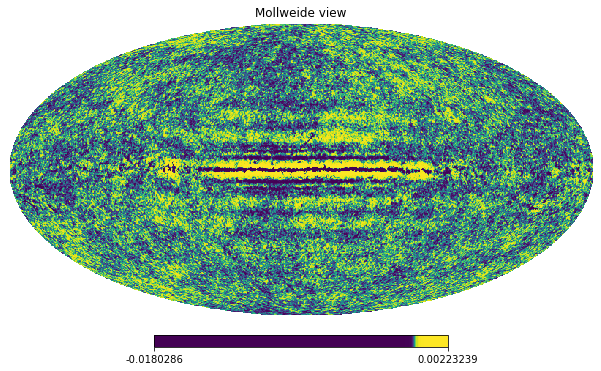

In [84]:
plt.show()
hp.mollview(CMB["TEB"][0], norm='hist')